# Cargar librerias a utilizar

In [39]:
# --- Librerías estándar y científicas ---
import numpy as np  # Manipulación de arreglos numéricos de N dimensiones
import matplotlib.pyplot as plt  # Creación de gráficos y visualizaciones
import matplotlib.colors as colors  # Manejo avanzado de mapeos de colores en gráficos
from mpl_toolkits.axes_grid1 import make_axes_locatable  # Control preciso del layout de los ejes en figuras matplotlib
from scipy.optimize import curve_fit  # Ajuste de curvas a funciones definidas
from scipy.spatial import cKDTree
import pandas as pd
import seaborn as sns

# --- Astropy: manejo de datos astronómicos ---
from astropy import units as u  # Manejo de unidades físicas
from astropy.coordinates import SkyCoord, match_coordinates_sky  # Manejo de coordenadas celestes y emparejamiento en el cielo
from astropy.io import fits  # Lectura y escritura de archivos FITS
from astropy.nddata import Cutout2D  # Extracción de recortes 2D de imágenes
from astropy.stats import sigma_clipped_stats  # Estadísticas robustas con eliminación sigma-clipping
from astropy.wcs import WCS  # Manejo de información de coordenadas WCS (World Coordinate System)
from astropy.table import QTable

# --- Photutils: detección y fotometría de fuentes ---
from photutils.detection import DAOStarFinder  # Detección de estrellas usando el algoritmo DAO
from photutils.aperture import CircularAperture, aperture_photometry  # Fotometría mediante aperturas circulares
from photutils.detection import find_peaks

# --- Astroquery: acceso a catálogos astronómicos ---
from astroquery.gaia import Gaia  # Consulta del catálogo Gaia usando ADQL


# Star Finder to PSF

In [40]:
# --- Configuración inicial ---
# Directorios
DIR = '/home/dcorrea/Escritorio/lens_QSO_inv/PSJ1606/'
OUTPUT_DIR = DIR + 'output/'

# Nombre del archivo fuente
filename = 'PSJ1606_muse_simple_X_zapped.fits'

# --- Lectura del cubo de datos FITS ---
with fits.open(DIR + filename) as hdul:
    cube = hdul[1].data           # Cubo de datos científicos
    vcube = hdul[2].data          # Varianza (para calcular errores)
    header = hdul[1].header       # Encabezado con información WCS

# WCS 2D para coordenadas espaciales
wcs_2d = WCS(header, naxis=2)

# Imagen de luz blanca (suma a lo largo del eje espectral)
white_img = np.nansum(cube, axis=0)
white_img_err = np.sqrt(np.nansum(vcube, axis=0))

# Vector de longitud de onda observado (en Å)
wave_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] - 1)) * header['CD3_3'] + header['CRVAL3']

# Espectro total sumando sobre las dos dimensiones espaciales
#spectrum = np.nansum(cube, axis=(1, 2))

# --- Cálculo de límites en coordenadas celestes ---
ny, nx = cube.shape[1:]
corners_x = [0, nx]
corners_y = [0, ny]

# Transformar píxeles de las esquinas a coordenadas RA/Dec
ra_dec = wcs_2d.pixel_to_world([corners_x[0], corners_x[1], corners_x[0], corners_x[1]],
                               [corners_y[0], corners_y[0], corners_y[1], corners_y[1]])

# Límites de la región en grados
ra_min, ra_max = ra_dec.ra.deg.min(), ra_dec.ra.deg.max()
dec_min, dec_max = ra_dec.dec.deg.min(), ra_dec.dec.deg.max()

# --- Consulta ADQL a Gaia ---
# Se usa un límite de magnitud (G < 19) para restringir a estrellas relativamente brillantes
# astrometric_params_solved > 3: buena solución astrométrica
# classprob_dsc_combmod_star > 0.5: probabilidad de ser estrella

query = f"""
SELECT TOP 10
    source_id, ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE ra BETWEEN {ra_min} AND {ra_max}
  AND dec BETWEEN {dec_min} AND {dec_max}
  AND phot_g_mean_mag < 22
  AND astrometric_params_solved > 3
  AND classprob_dsc_combmod_star > 0.5
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job(query)
gaia_results = job.get_results()
print(gaia_results, "\n")


     source_id              ra                 dec         phot_g_mean_mag
                           deg                 deg               mag      
------------------- ------------------ ------------------- ---------------
6242307018500802048 241.51482538958737 -23.556558458360637       15.671239
6242307048556613376 241.49989742785178   -23.5628218960989       17.557453
6242307082916379008 241.50788684016024  -23.55287888154344       17.780014
6242307052852617856  241.4907407490663 -23.559823599740504       18.049698
6242307048557549056 241.49276723423299 -23.567343122887138       18.302149
6242307014196859904 241.51405830984802  -23.56828658714226        18.61709
6242307014196860032 241.51562384550382   -23.5687570005305       18.916084
6242307048556628096 241.49036667441862  -23.55697362007846       18.920118
6242307396457927808 241.51372455488635  -23.55069310126085       19.144053
6242307289074827776 241.49273418403286 -23.545222009136292       19.292034 



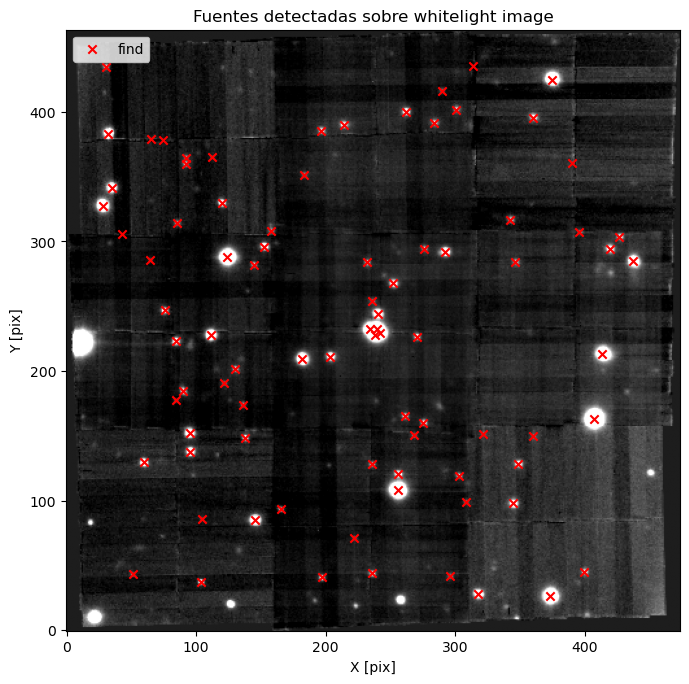

In [41]:

# --- Detección de fuentes con DAOStarFinder ---
# Se usa un umbral de 3 sigma sobre la mediana

mean, median, std = sigma_clipped_stats(white_img, sigma=3.0)
daofind = DAOStarFinder(fwhm=3.0, threshold=3.0 * std)
sources = daofind(white_img - median)

# Coordenadas (x, y) de las fuentes detectadas
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

# --- Filtro para excluir fuentes cerca del borde ---
# Elimina detecciones a menos de X px del borde
MARGIN = 25
inside_mask = (
    (positions[:, 0] > MARGIN) & (positions[:, 0] < nx - MARGIN) &
    (positions[:, 1] > MARGIN) & (positions[:, 1] < ny - MARGIN)
)
positions = positions[inside_mask]

# --- Visualización de la imagen y fuentes detectadas ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))
plt.scatter(positions[:, 0], positions[:, 1], marker='x', color='red', label='find')
plt.title('Fuentes detectadas sobre whitelight image')
plt.xlabel('X [pix]')
plt.ylabel('Y [pix]')
plt.legend(loc="upper left")
plt.grid(False)
plt.tight_layout()
plt.show()


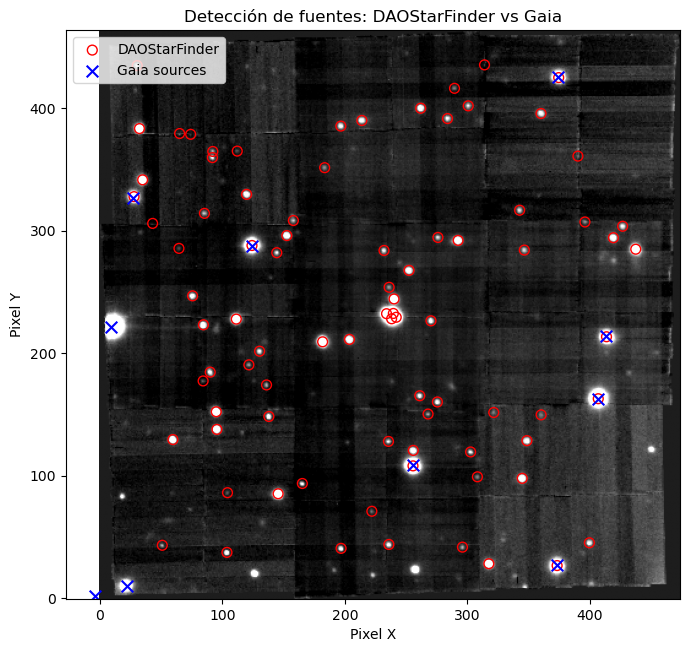

In [42]:
# --- Transformar coordenadas de GAIA (RA, Dec) a píxeles ---

rel_pos_ra, rel_pos_dec = 0.0001*3 ,-0.0005*1.4

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
gaia_pixels = wcs_2d.world_to_pixel(gaia_coords_corr)


# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(positions[:, 0], positions[:, 1], s=50, edgecolor='red', facecolor='none', marker='o', label='DAOStarFinder')

# Fuentes Gaia transformadas (azul)
plt.scatter(gaia_pixels[0], gaia_pixels[1], s=70, color='blue', marker='x', label='Gaia sources')

plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes: DAOStarFinder vs Gaia')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Number of matches: 7

Number of clean matches: 6

[[373.21030579  26.57237514]
 [406.78734554 162.74561609]
 [413.52051692 213.32342591]
 [124.14649836 287.81265587]
 [ 27.86814422 327.67988064]
 [374.49381479 424.83183647]]
 ID     img_RA_deg        img_Dec_deg    
--- ------------------ ------------------
  1 241.49306874348522 241.49306874348522
  2 241.49103391434213 241.49103391434213
  3  241.4906259593612  241.4906259593612
  4  241.5081635797751  241.5081635797751
  5  241.5139982095509  241.5139982095509
  6 241.49299156223728 241.49299156223728


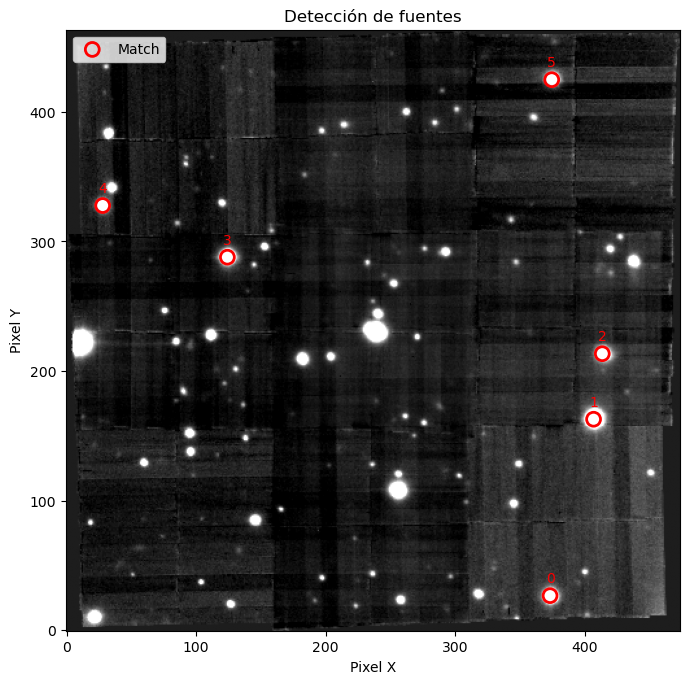

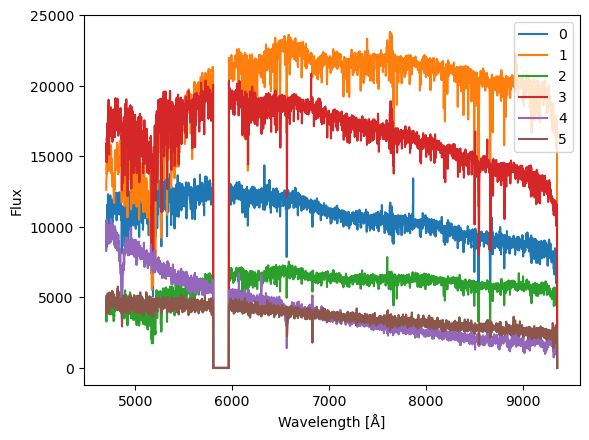

In [43]:
# --- Transformación pixeles a coordenadas celestes (fuentes encontradas) ---
sources_sky_coords = wcs_2d.pixel_to_world(positions[:, 0], positions[:, 1])

# --- Cruce de posiciones con Gaia ---
#gaia_coords = SkyCoord(ra=gaia_results['ra'], dec=gaia_results['dec'], unit='deg')

rel_pos_ra, rel_pos_dec = 0.0001*3 ,-0.0005*1.4

gaia_coords_corr = SkyCoord(ra=gaia_results['ra']+rel_pos_ra, dec=gaia_results['dec']+rel_pos_dec, unit='deg')
idx, d2d, _ = match_coordinates_sky(sources_sky_coords, gaia_coords_corr)

# Selecciona coincidencias dentro de 2 arcsec
MATCH_RADIUS = 2.0 * u.arcsec
matched = d2d <= MATCH_RADIUS

print(f"Number of matches: {np.sum(matched)}\n")

# Obtener posiciones y coordenadas coincidentes
matched_positions = positions[matched]
matched_coords = sources_sky_coords[matched]
#stars_coords = np.column_stack((matched_coords.ra.deg, matched_coords.dec.deg))
#print(matched_coords, "\n")
#print(" ")
#matched_coords_gaia = gaia_coords_corr[idx[matched]]
#print(matched_coords_gaia, "\n")


# Usar TODAS las detecciones (positions) para filtrar objetos cercanos
tree_all = cKDTree(positions)
distances, _ = tree_all.query(matched_positions, k=2)  # para cada matched, obtener vecino más cercano
nearest_neighbor_dist = distances[:, 1]

min_sep_pixels = 15  # umbral en píxeles para considerar que una estrella está contaminada
isolated_mask = nearest_neighbor_dist > min_sep_pixels

matched_positions_nocont = matched_positions[isolated_mask]
matched_coords_nocont = matched_coords[isolated_mask]

print(f"Number of clean matches: {len(matched_coords_nocont)}\n")


print(matched_positions_nocont)

# --- Tabla ordenada con los datos emparejados sin contaminacion -- 
matched_table = QTable()
matched_table['ID'] = np.arange(1, np.sum(isolated_mask)+1)
matched_table['img_RA_deg'] = matched_coords_nocont.ra.deg
matched_table['img_Dec_deg'] = matched_coords_nocont.ra.deg
print(matched_table)



# --- Mostrar imagen con detecciones DAOStarFinder y Gaia ---
plt.figure(figsize=(7, 7))
plt.imshow(white_img, origin='lower', cmap='gray', vmin=np.percentile(white_img, 5), vmax=np.percentile(white_img, 99))

# Fuentes detectadas por DAOStarFinder (rojo)
plt.scatter(matched_positions_nocont[:, 0], matched_positions_nocont[:, 1], s=100,linewidths=2, edgecolor='red', facecolor='none', marker='o', label='Match')
for i, (x, y) in enumerate(matched_positions_nocont):
    plt.text(x, y + 10, str(i), color='red', fontsize=10, ha='center')


plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.title('Detección de fuentes')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



# --- Espectros de las estrellas tomadas ---

pixel_scale = 0.2  # arcsec/pixel
aperture_radius_pix = 1 / pixel_scale

for i, pos in enumerate(matched_positions_nocont):
    y, x = int(pos[1]), int(pos[0])
    yy, xx = np.ogrid[:cube.shape[1], :cube.shape[2]]
    mask = (xx - x)**2 + (yy - y)**2 <= aperture_radius_pix**2
    spectrum_obj = np.nansum(cube[:, mask], axis=1)
    plt.plot(wave_obs, spectrum_obj, label=f'{i}')

plt.xlabel('Wavelength [Å]')
plt.ylabel('Flux')
plt.legend()
plt.show()

# PSF and object treatmen


## Metodo artesanal de PSF

### Funciones de utilidad

In [44]:
# Some useful functions:
# Get an azimuthal-averaged radial profile by using some radial coordinates
def radial_prof(img, rcoord, width=2.0, model=None, check_zeros=True):    
    if check_zeros:
        zeros = img == 0
        img[zeros] = np.nan
        
        if model is not None:
            model[zeros] = np.nan

    rcoord_norm = rcoord // width
        
    r_arr, prof_arr, model_arr = [], [], []
    for r in np.unique(rcoord_norm):            
        sel = rcoord_norm == r
        
        img_sel = img[sel]
        if len(img_sel) < 1:  # just in case only one pixel is selected.
            continue
        
        r_arr.append(r)
        prof_arr.append(np.nanmean(img_sel))
        
        if model is not None:
            model_arr.append(np.nanmean(model[sel]))
        
    if model is None:
        model_arr = np.nan    
    
    return np.array(r_arr), np.array(prof_arr), np.array(model_arr)

# Two-dimensional (circular) Moffat profile
def moffat2D(coord, *params): # params: x0, y0, fwhm, beta, amplitude

    x, y = coord
    x0, y0, amplitude, fwhm, beta, = params

    alpha = fwhm / 2. / np.sqrt(2**(1./beta)-1)
    r2 = (x - x0)**2 + (y - y0)**2
    model = amplitude / (1 + r2/alpha**2)**beta
    
    return model.ravel()

# 2D Sersic model. Could be useful.
def sersic2D(coord, pars):
    x, y = coord
    x0, y0, PA, Q, I0, Re, n = pars 
    
    xr = (x-x0) * np.cos(PA) + (y-y0) * np.sin(PA)
    yr = -(x-x0) * np.sin(PA) + (y-y0) * np.cos(PA)
    R = np.sqrt(xr**2 + (yr/Q)**2)
    
    bn = 2*n-0.333
    z = I0 * np.exp(-bn * (R/Re)**(1/n))
    
    return z.ravel()

# Fit the lensed qso image. It assumes a moffat2D function is called.
def lens_qso_fit(coord, *params):

    z = np.zeros(np.shape(coord[0])).ravel()
    for i in range(0, len(params), 5):
        
        subparams = params[i:i+5]
        z += moffat2D(coord, *subparams)
        
    #z += sersic2D(coord, params[-7:])
    
    return z

# Auxiliar plot function
def do_imshow_plot(img, mod, res, Npars=0, ncols=3, mask=None, title=None):
    # Ploting cutout image and model
    fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols,3))

    minval = np.nanmin(img) # to re-scale and not consider negative values
    if mask is not None:
        p = np.nanpercentile(img[mask]-minval, [16, 99.5]) # to normalize color scale
    else:
        p = np.nanpercentile(img-minval, [16, 99.5])
               
    col_norm=colors.LogNorm(vmin=p[0], vmax=p[1])
    
    ax[0].imshow(img-minval, origin='lower', norm=col_norm)
    ax[1].imshow(mod-minval, origin='lower', norm=col_norm)
    
    im = ax[2].imshow(res, origin='lower', vmin=-5, vmax=5, cmap='RdBu_r')
        
    # color bar for residuals
    cax = fig.add_axes([0.69, 0.24, 0.075, 0.025])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
    cbar.ax.set_xticklabels([r'-5$\sigma$', '0', r'5$\sigma$'])
    
    # some text
    ax[0].text(0.02, 0.9, 'Star', color='w', transform=ax[0].transAxes)
    ax[1].text(0.02, 0.9, 'Model', color='w', transform=ax[1].transAxes)
    ax[2].text(0.02, 0.9, 'Residuals', color='k', transform=ax[2].transAxes)
    
    if mask is not None:    
        chi2_r = np.nansum(res**2) / (img.size-Npars)      # reduced chi-square value
    else:
        chi2_r = np.nansum(res[mask]**2) / (img[mask].size-Npars)

    ax[1].text(0.6, 0.9, r'$\chi^2_\nu = $'+format(chi2_r,'.5f'), 
                          color='w', 
                          transform=ax[1].transAxes)
    
    if title is not None:
        ax[1].set_title(title)

    for i in range(ncols):
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    plt.show()

    return chi2_r

### Star PSF modeling (White-Image) and normalization

FWHM = 3.1528200326906552       Beta = 2.4170880933362406


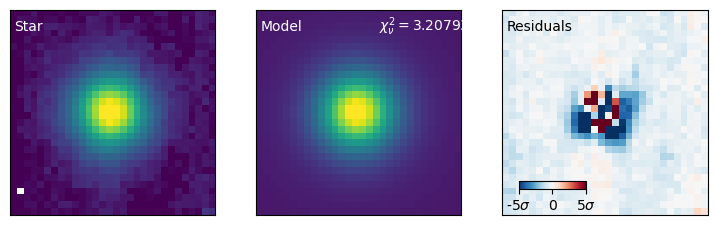

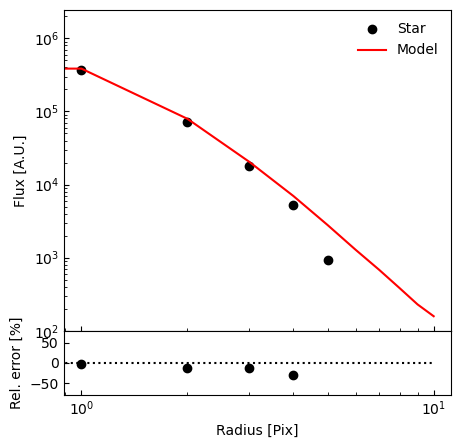

FWHM = 4.282395669336644       Beta = 2.941573551015564


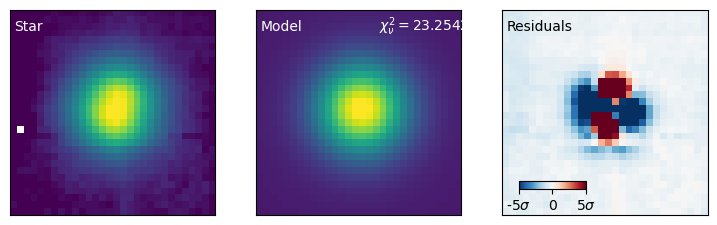

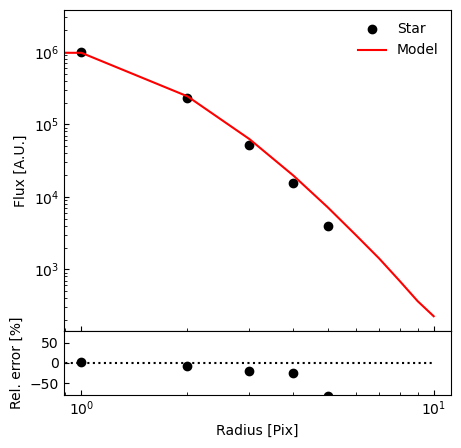

FWHM = 3.218442542914461       Beta = 1.8157529476211671


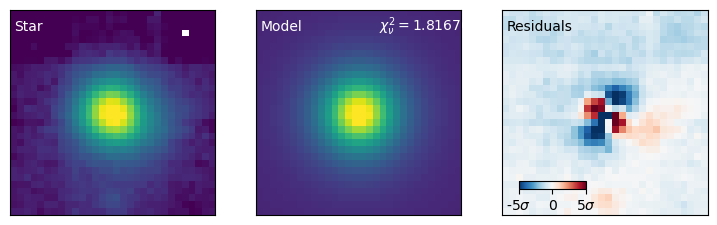

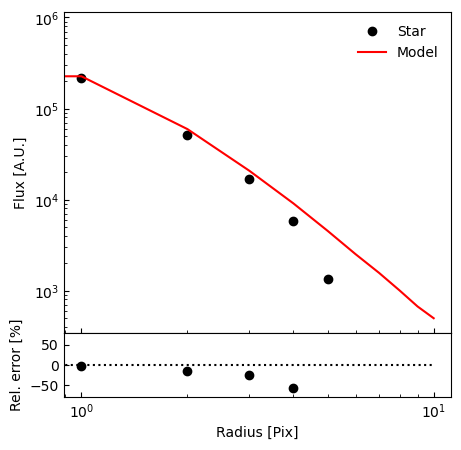

FWHM = 2.6164930267364164       Beta = 2.2931015402380135


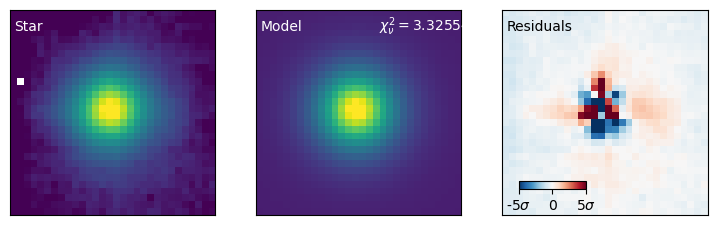

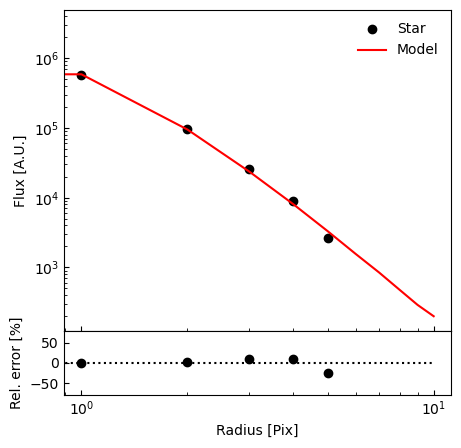

FWHM = 3.108812743998894       Beta = 2.2446961720688123


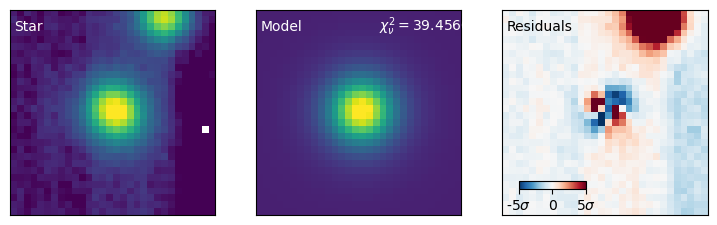

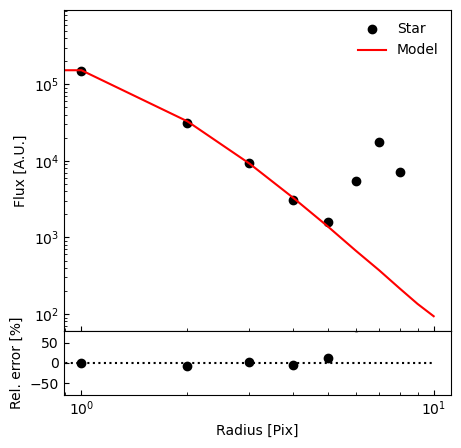

FWHM = 4.277038417890503       Beta = 2.488843668897654


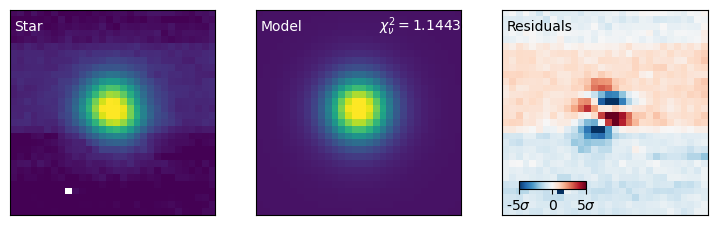

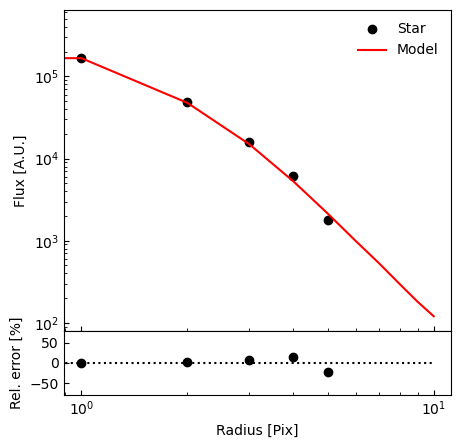

[[np.float64(3.1528200326906552), np.float64(2.4170880933362406)], [np.float64(4.282395669336644), np.float64(2.941573551015564)], [np.float64(3.218442542914461), np.float64(1.8157529476211671)], [np.float64(2.6164930267364164), np.float64(2.2931015402380135)], [np.float64(3.108812743998894), np.float64(2.2446961720688123)], [np.float64(4.277038417890503), np.float64(2.488843668897654)]]


In [45]:
star_radec  = np.column_stack((matched_coords_nocont.ra.deg, matched_coords_nocont.dec.deg))

FHMW_Beta_list = []
flux_list = []
images_chi2 = []

for i, (ra, dec) in enumerate(star_radec):
    
    # Crear objeto SkyCoord con RA y Dec en grados
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')


    # Definir el tamaño del recorte en pixeles
    cutout_size = 30
    #if i == len(star_radec) - 2:
    #    cutout_size = 80


    # Crear recorte en imagen de luz blanca
    cutout = Cutout2D(white_img, coord, size=cutout_size, 
                      wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img = cutout.data
    cutout_wcs = cutout.wcs
    del cutout

    # Crear recorte en imagen de error
    aux = Cutout2D(white_img_err, coord, size=cutout_size, 
                   wcs=wcs_2d, mode='partial', fill_value=0) 
    cutout_img_err = aux.data
    del aux

    # -------------------------------------------------------------- #

    # Making the pixel grid that will used during the fit.
    szy, szx = np.shape(cutout_img)
    x, y = np.meshgrid(np.arange(szx), np.arange(szy))

    # One star is at the edge of the datacube, so its cutout 
    # image is filled with zero values for pixels with no data
    # I avoid these pixels in the fit
    # Máscara de píxeles válidos

    #no_zeros = cutout_img != 0
    #x_aux = x[no_zeros]
    #y_aux = y[no_zeros]
    #cutout_img_aux = cutout_img[no_zeros]
    #cutout_img_err_aux = cutout_img_err[no_zeros]


    # Avoiding pixels with 0 or NaN values 
    mask = (cutout_img == 0) | (np.isnan(cutout_img))
    x_aux = x[~mask]
    y_aux = y[~mask]

    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    norm = np.nanmax(cutout_img_aux)

    cutout_img_err_aux /= norm 
    cutout_img_aux /= norm



    # Calculate background statistics for the cutout image and
    # subtract the background. I should add the background 
    # uncertainty to the error budget, but I am *not* doing this.
    
    _, median, std = sigma_clipped_stats(cutout_img_aux*norm, sigma=3.0)

    #std = np.nanstd(cutout_img_aux)

    cutout_img_corr = cutout_img - median
    #cutout_img_aux_corr = cutout_img_aux - median
    
    # Setting the initial guesses and model the star
    guess = [cutout_size/2, cutout_size/2, np.nanmax(cutout_img_corr), 2.2, 4.0]

    popt_psf, pcov_psf = curve_fit(moffat2D, 
                                   (x_aux, y_aux), 
                                   cutout_img_aux.ravel(), 
                                   p0=guess,
                                   absolute_sigma=True, 
                                   sigma=cutout_img_err_aux.ravel())
    

    print("FWHM =", list(popt_psf[3:])[0],"     ","Beta =",list(popt_psf[3:])[1])

        
    FHMW_Beta_list.append(list(popt_psf[3:]))
    flux_list.append(popt_psf[2])

    # Obtain the best fit. Note that as I am fitting the auxiliar array
    # without zero values, I need to re-arrange the best-fit output to 
    # a 2D array following the cutout image size.
    fit_aux = moffat2D((x_aux, y_aux), *popt_psf)
    fit = cutout_img_corr*0
    fit[~mask] = fit_aux * norm
    
    residuals = (cutout_img_corr-fit) / std      # Residuals w.r.t. the image noise

    # Plotting images 
    chi_2 = do_imshow_plot(cutout_img_corr, fit, residuals, Npars=len(popt_psf), 
                                               mask=~mask)
    # Extracting radial profiles to provide better comparison
    radius =  np.sqrt((x-popt_psf[0])**2 + (y-popt_psf[1])**2) # circular apertures


    r_prof, img_prof, fit_prof = radial_prof(cutout_img_corr, 
                                             radius, 
                                             model=fit)
    

    images_chi2.append(chi_2)

    # Plotting radial profile
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(r_prof, img_prof, 'ok', label='Star')
    ax.plot(r_prof, fit_prof, '-r', label='Model')
    
    ax.legend(frameon=False)  
    
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.tick_params(axis="both", direction="in", which='both')

    ax.set_ylabel('Flux [A.U.]')

    divider = make_axes_locatable(ax)
    ax2 = divider.append_axes("bottom", size="20%", pad=0)


    ax.figure.add_axes(ax2)
        
    ax2.plot(r_prof, 100*(1 - fit_prof/img_prof), 'ok')
    ax2.plot(r_prof, img_prof*0, ':k', linewidth=1.5)

    ax2.set_ylim([-79, 79])
    ax2.set_xscale('log')
    ax2.tick_params(axis="both", direction="in",which='both')
    
    ax2.set_ylabel('Rel. error [%]')
    ax2.set_xlabel('Radius [Pix]')
    
    plt.show()


print(FHMW_Beta_list)

## Fitting del quasar (whitelight image)

### Con imagenes NO normalizadas

x_peak y_peak peak_value
------ ------ ----------
    28     24  1008631.3
    32     25  1229902.2
    24     28  1404201.9
    30     29   883758.2
    30     40   353617.2
    26     50   24754.11


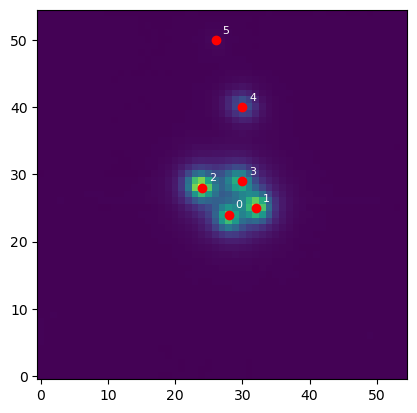

[np.float64(4.277038417890503), np.float64(2.488843668897654)]
non free:  0
non free:  1
non free:  2
non free:  3
free:  4
free:  5


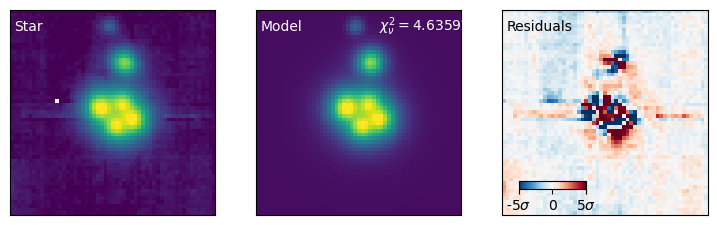

   Fuente          x          y         flujo      FWHM       beta
0       0  27.915901  23.566371  9.923994e+05  3.152852   2.417064
1       1  32.147277  25.134344  1.207343e+06  3.152852   2.417064
2       2  23.917993  28.158405  1.380553e+06  3.152789   2.417064
3       3  29.498584  28.854516  9.048271e+05  3.152852   2.417064
4       4  30.065502  40.171046  3.758468e+05  3.275857   2.982463
5       5  26.062108  49.721703  2.369515e+04  3.000331  14.631972


In [46]:


white_img = np.nansum(cube, axis=0)

ra, dec = 241.5013, - 23.5567

star_psf = FHMW_Beta_list[0]       # PSF MODEL SELECTION

cutout_size = 55    # in pixel units



################ mask attemp ############## 

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#mask = (x - 238)**2 + (y - 251)**2 <= 12**2

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)

#-----------------------------------------#


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

# Make cutout for the white-light image and its error image
cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 
mean, median, std = sigma_clipped_stats(qso_img, sigma=3.0)
qso_img -= median  # rough background subtraction

threshold = 5* std                # Threshold for peak detection
tbl = find_peaks(qso_img, threshold, box_size=5)

xpeak, ypeak, peakval = tbl['x_peak'], tbl['y_peak'], tbl['peak_value']


print(tbl[["x_peak","y_peak","peak_value"]])


Nsources = len(xpeak)

plt.imshow(qso_img, origin='lower')  # Checking peaks location
plt.plot(xpeak, ypeak, 'or')
for i in range(len(xpeak)):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Now we prepare the initial guess for the fit. I assume each components 
# are centered at the repective peak location, but I consider some small 
# center mismatch. Similar asumption is made for the peak value. The PSF 
# shape values fixed are by setting very strict lower and upper bounds. 
# I do not like this from a methology point of view, but for this example
# this is good enough. You can use another packages like "lmfit" to do 
# it in properly. 
guess, up_bounds, lo_bounds = [], [], []

print(list(popt_psf[3:]))

#for i in range(Nsources):
#    guess += [xpeak[i], ypeak[i], peakval[i]] + list(star_psf)
#    up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.1*peakval[i]] + [x * 1.00001 for x in star_psf]
#    lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.99999 for x in star_psf]
#    print(peakval[i])

for i in range(Nsources):
    #print(peakval[i])
    if peakval[i] < 453617:  #colocar valor absurdo para dejar libre FWHM y Beta
        guess += [xpeak[i], ypeak[i], peakval[i]] + list(popt_psf[3:])
        
        # Libertad espacial y de intensidad
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0.1*peakval[i]]
        
        # Libertad del perfil Moffat: FWHM ∈ [1, 10], β ∈ [1.5, 5]
        up_bounds += [20.0, 20.0]
        lo_bounds += [0.5, 1]
        print("free: ", i)
    else:
        print("non free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]] + list(star_psf)
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.1*peakval[i]] + [x * 1.00001 for x in star_psf]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.99999 for x in star_psf]
        #print(peakval[i])


# For doing 2D Sersic fit. Not adopted here...
#guess += [szx/2, szy/2, 45, 0.3, np.min(peakval)*0.1, 2, 1]
#up_bounds += [szx/2+10, szy/2+10, 179.9, 0.95, np.min(peakval), 10, 6]
#lo_bounds += [szx/2-10, szy/2-10, 0, 0.05, 0, 0.5, 0.8]

# Do the fit
popt, pcov = curve_fit(lens_qso_fit, 
                       (x, y), 
                       qso_img.ravel(), 
                       p0=guess,
                       sigma=qso_img_err.ravel(),
                       bounds=(lo_bounds, up_bounds))


# Obtain the best fit. Note that the best-fit needs to be re-arranged
# to a 2D array following the cutout image size.
fit = lens_qso_fit((x,y), *popt).reshape(szy,szx)

residuals = (qso_img - fit) / std     # Residuals w.r.t. the image noise

# Plotting images 
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))



param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)



### Con imagenes normalidazas


x_peak y_peak peak_value
------ ------ ----------
    28     24  1008631.3
    32     25  1229902.2
    24     28  1404201.9
    30     29   883758.2
    30     40   353617.2
    26     50   24754.11
 peak_value
-----------
  0.7177807
 0.87524563
  0.9992839
  0.6289162
 0.25164756
0.017615974


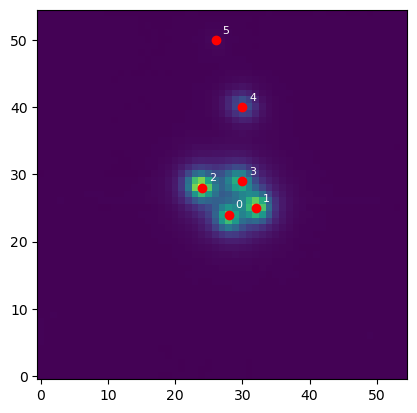

non_free:  0
non_free:  1
non_free:  2
non_free:  3
free:  4
free:  5


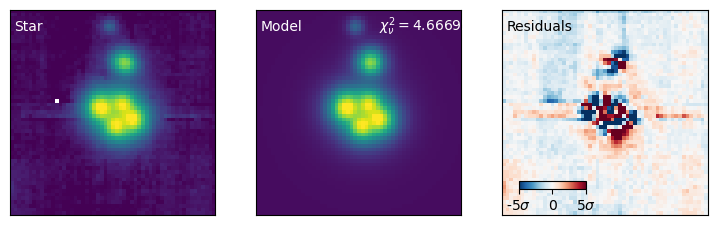

   Fuente          x          y     flujo      FWHM      beta
0       0  27.915080  23.564873  0.707713  3.153451  2.416605
1       1  32.149046  25.133631  0.860731  3.153451  2.416605
2       2  23.916640  28.158644  0.984725  3.152189  2.416605
3       3  29.498633  28.855105  0.645174  3.153451  2.416605
4       4  30.066297  40.171491  0.270291  3.246170  2.642116
5       5  26.047145  49.729608  0.017423  3.095214  5.689443


In [47]:
white_img = np.nansum(cube, axis=0)

ra, dec = 241.5013, - 23.5567      # Coordenadas del objeto (img. frame reference)

star_psf = FHMW_Beta_list[0]       # PSF MODEL SELECTION

cutout_size = 55    # in pixel units (Make cutout for the white-light image and its error image)


################ mask attemp ############## 

#y, x = np.ogrid[:white_img.shape[0], :white_img.shape[1]]
#mask = (x - 238)**2 + (y - 251)**2 <= 12**2

#white_img[mask] = np.random.normal(loc=1000, scale=2000)
#white_img[mask] = np.random.normal(loc=-0.375138, scale=14.1206, size=white_img[mask].shape)

#-----------------------------------------#


coord = SkyCoord(ra, dec, unit='deg', frame='icrs')

cutout = Cutout2D(white_img, coord, size=cutout_size, 
                               wcs=wcs_2d,
                               mode='partial', 
                               fill_value=0) 
qso_img = cutout.data
qso_wcs = cutout.wcs
del cutout

aux = Cutout2D(white_img_err, coord, size=cutout_size,
                                wcs=wcs_2d,
                                mode='partial', 
                                fill_value=0) 
qso_img_err = aux.data
del aux

# Making the pixel grid that will used during the fit.
szy, szx = np.shape(qso_img)
x, y = np.meshgrid(np.arange(szx), np.arange(szy))

# Calculate background statistics for the cutout image and
# find how may sources are within this image. Note that the
# flux threshold used for define a "significant detection" 
# depends on the noise level of the image. Here, I use the
# photutils.find_peaks routine 



# Avoiding pixels with 0 or NaN values 
mask = (qso_img == 0) | (np.isnan(qso_img))
x_aux = x[~mask]
y_aux = y[~mask]

qso_img_aux = qso_img[~mask]
qso_img_err_aux = qso_img_err[~mask]

norm = np.nanmax(qso_img_aux)


qso_img_aux /= norm
qso_img_err_aux /= norm 

mean, median, std = sigma_clipped_stats(qso_img_aux*norm, sigma=3.0)
qso_img -= median  # rough background subtraction


threshold = 5* std                # Threshold for peak detection
tbl = find_peaks(qso_img, threshold, box_size=5)

xpeak, ypeak, peakval = tbl['x_peak'], tbl['y_peak'], tbl['peak_value']

print(tbl[["x_peak", "y_peak", "peak_value"]])
print(peakval/norm)


Nsources = len(xpeak)

# Visualización rápida
plt.imshow(qso_img, origin='lower')
plt.plot(xpeak, ypeak, 'or')
for i in range(Nsources):
    plt.text(xpeak[i] + 1, ypeak[i] + 1, str(i), color='white', fontsize=8)
plt.show()

# Construcción de parámetros iniciales y límites
guess, up_bounds, lo_bounds = [], [], []

for i in range(Nsources):
    if peakval[i]/norm < 0.3:   #0.3 deja qso fijo a psf y otros free; 0:all_non_free
        print("free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(popt_psf[3:])
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.5*peakval[i]/norm, 20.0, 20.0]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0.01*peakval[i]/norm, 0.5, 1]
    else:
        print("non_free: ", i)
        guess += [xpeak[i], ypeak[i], peakval[i]/norm] + list(star_psf)
        up_bounds += [xpeak[i]+10, ypeak[i]+10, 1.1*peakval[i]/norm] + [x * 1.0002 for x in star_psf]
        lo_bounds += [xpeak[i]-10, ypeak[i]-10, 0] + [x * 0.9998 for x in star_psf]

# Ajuste con modelo Moffat múltiple
popt, pcov = curve_fit(lens_qso_fit,
                       (x, y),
                       qso_img_aux.ravel(),
                       p0=guess,
                       sigma=qso_img_err_aux.ravel(),
                       bounds=(lo_bounds, up_bounds))

# Evaluación del modelo y visualización
fit_aux = lens_qso_fit((x, y), *popt)
fit = np.zeros_like(qso_img)
fit[~mask] = fit_aux * norm  # se escala el modelo a la imagen original

residuals = (qso_img - fit) / std  # residuo en unidades de sigma

# Gráfico final
do_imshow_plot(qso_img, fit, residuals, Npars=len(popt))

# Construcción de tabla con parámetros
param_list = []
for i in range(Nsources):
    param_list.append({
        "Fuente": i,
        "x": popt[i*5 + 0],
        "y": popt[i*5 + 1],
        "flujo": popt[i*5 + 2],
        "FWHM": popt[i*5 + 3],
        "beta": popt[i*5 + 4]
    })

df = pd.DataFrame(param_list)
print(df)



rangos con parametros libres (no PSF based):  -------   FWHM = [3, 3.3] ------ Beta = [2.19, 3.2] ------

# Go trought wavelenght (Start test)

In [48]:
import warnings
from scipy.optimize import OptimizeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)


## Multiframe

### test - Normalized

In [49]:
print(FHMW_Beta_list)

[[np.float64(3.1528200326906552), np.float64(2.4170880933362406)], [np.float64(4.282395669336644), np.float64(2.941573551015564)], [np.float64(3.218442542914461), np.float64(1.8157529476211671)], [np.float64(2.6164930267364164), np.float64(2.2931015402380135)], [np.float64(3.108812743998894), np.float64(2.2446961720688123)], [np.float64(4.277038417890503), np.float64(2.488843668897654)]]


<SkyCoord (ICRS): (ra, dec) in deg
    (241.49306874, -23.56806976)>
param: 12.06447273, bounds: [10.0, 20.0], in bounds: True
param: 11.84000283, bounds: [10.0, 20.0], in bounds: True
param: 1.07655817, bounds: [0.899464867193294, 1.6864966259874261], in bounds: True
param: 3.06052643, bounds: [2.522256026152524, 4.729230049035983], in bounds: True
param: 2.66879, bounds: [1.9336704746689926, 3.625632140004361], in bounds: True
----------------------------------------------------------------------------
[0,50]


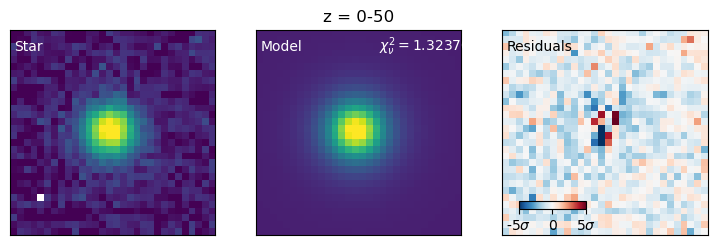

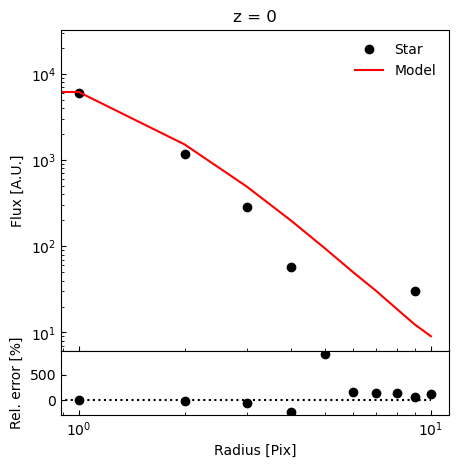

[200,250]


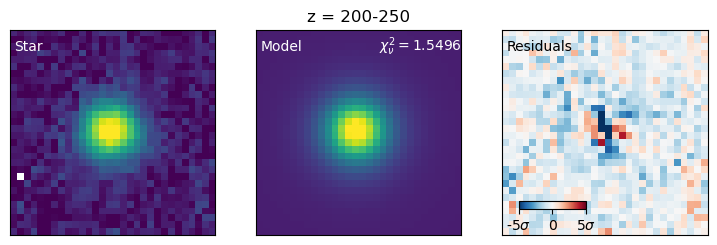

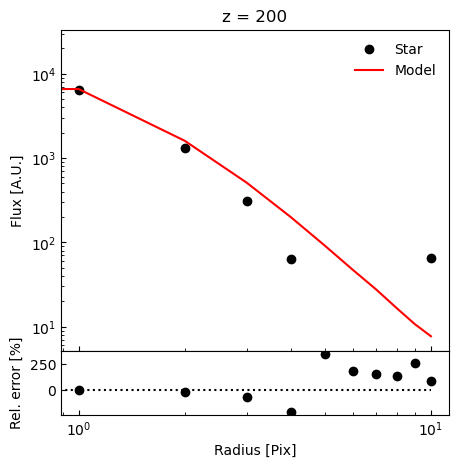

[400,450]


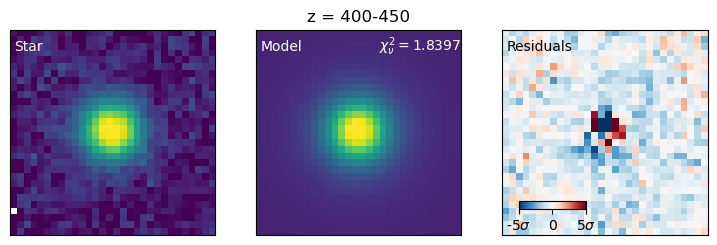

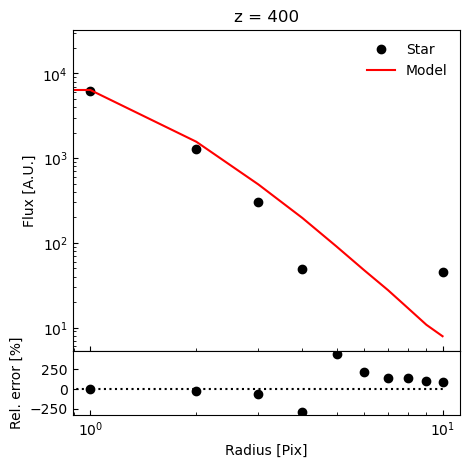

[600,650]


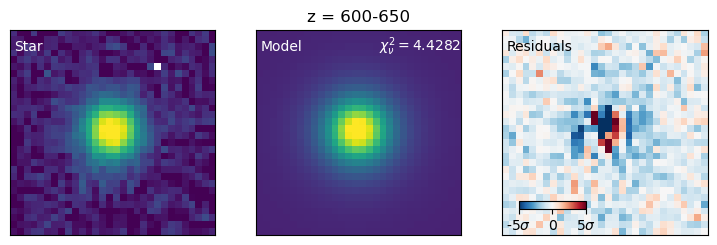

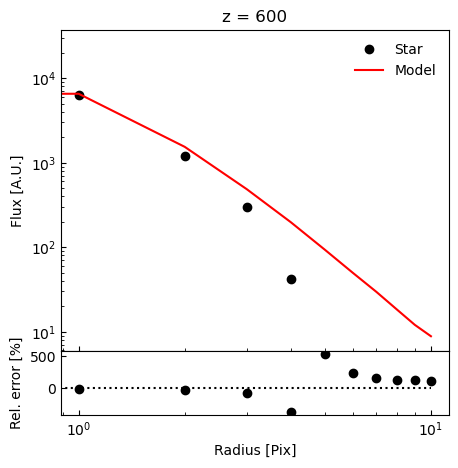

[800,850]


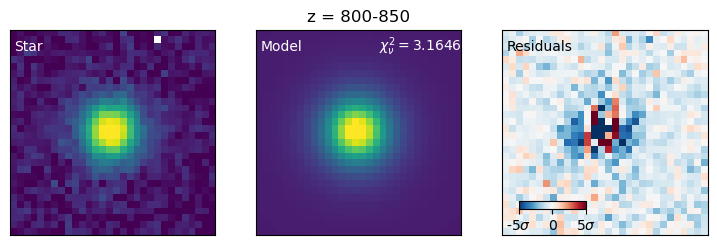

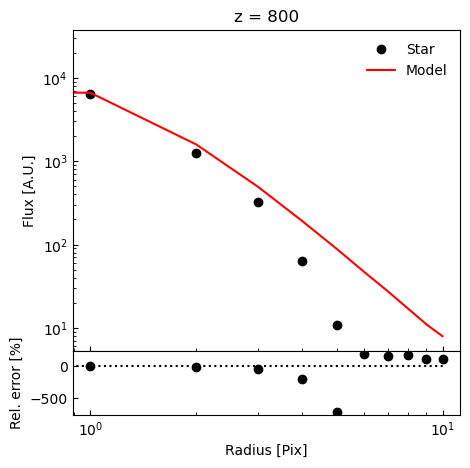

[1000,1050]


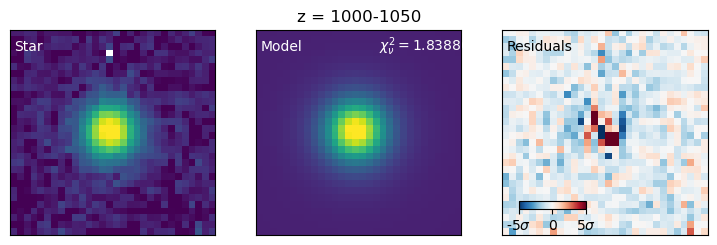

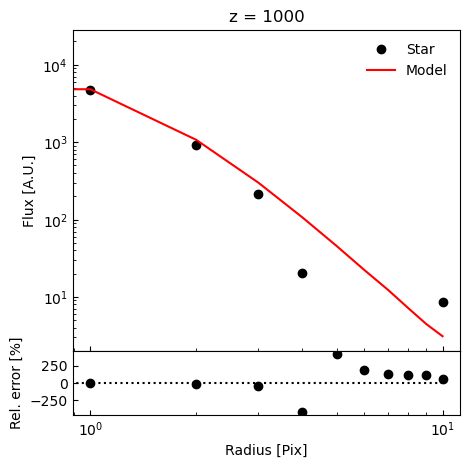

[1200,1250]


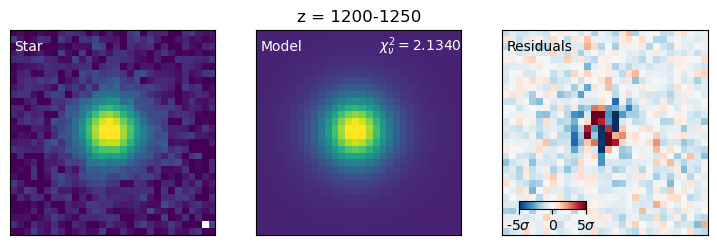

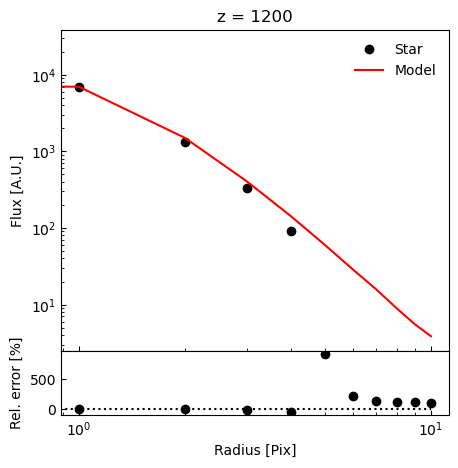

[1400,1450]


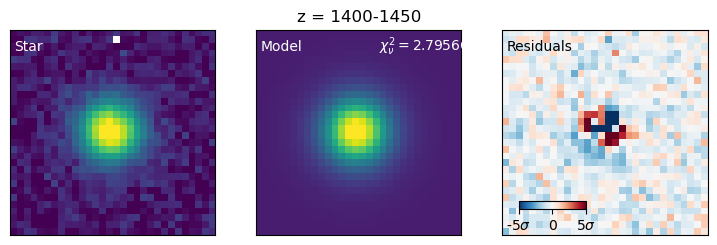

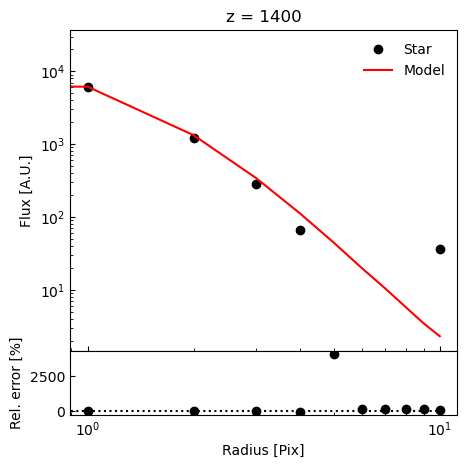

[1600,1650]


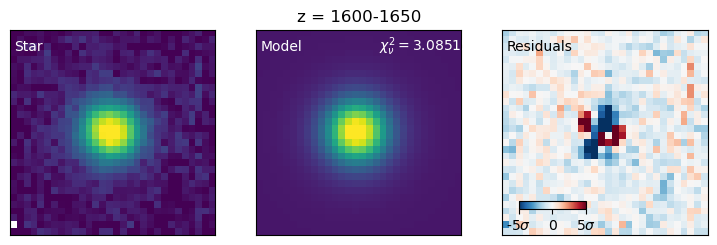

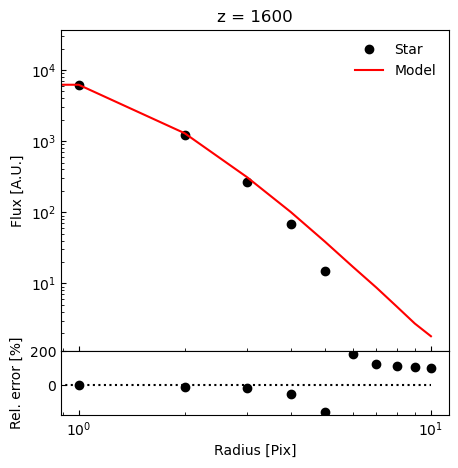

[1800,1850]


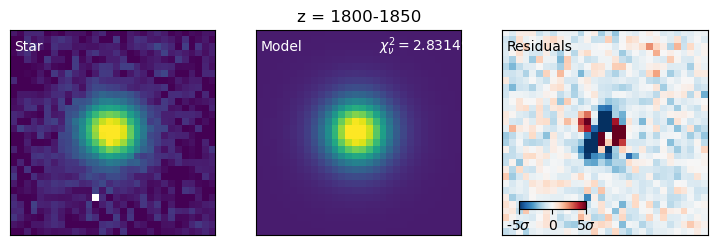

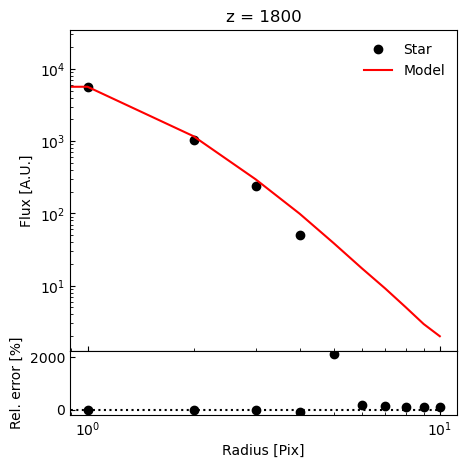

[2000,2050]


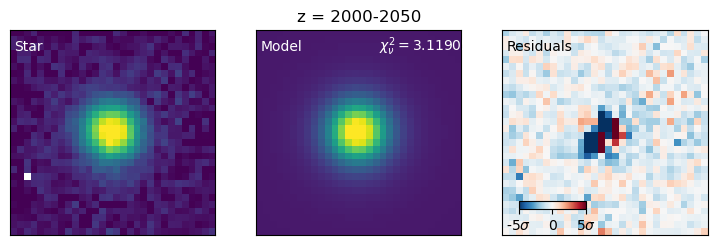

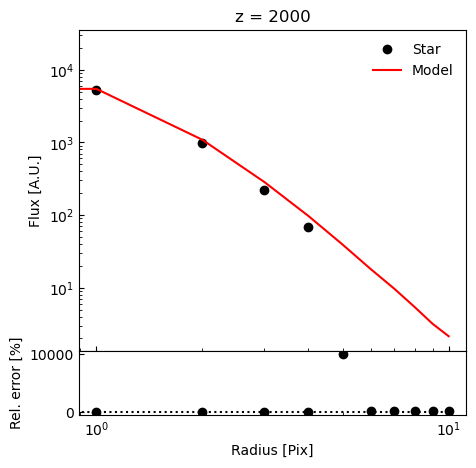

[2200,2250]


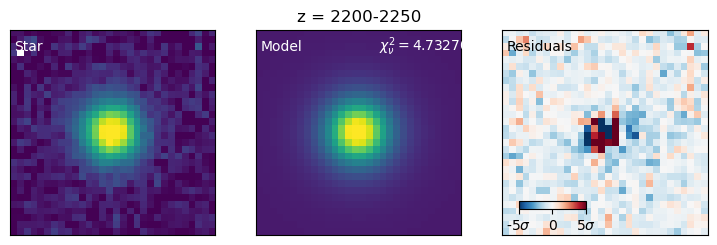

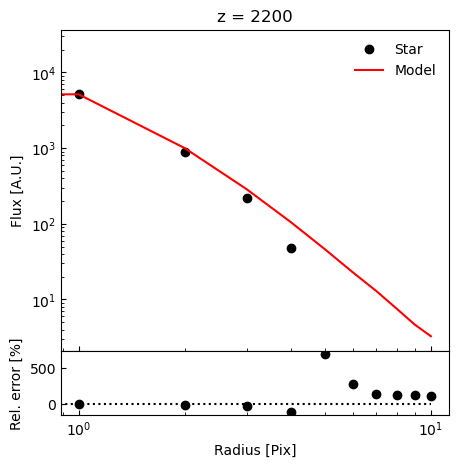

[2400,2450]


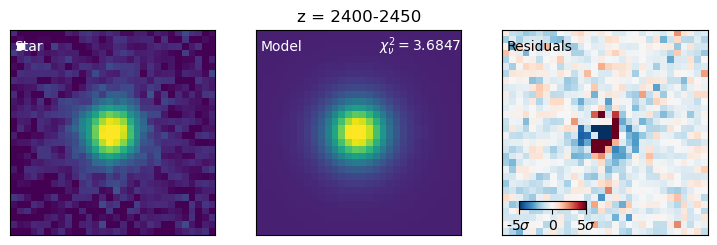

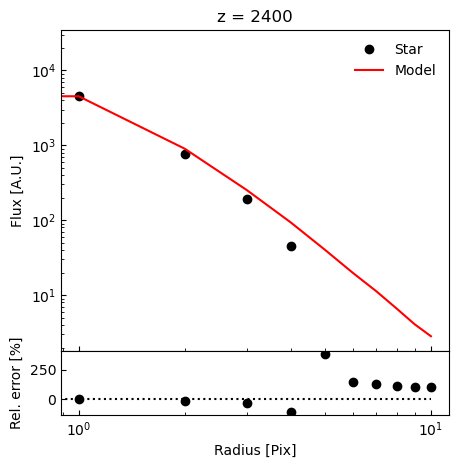

[2600,2650]


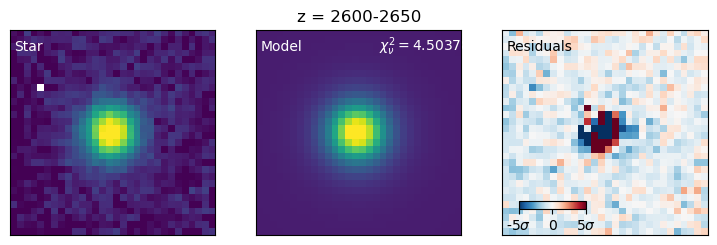

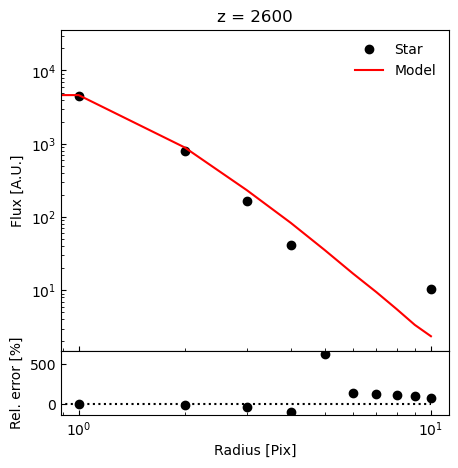

[2800,2850]


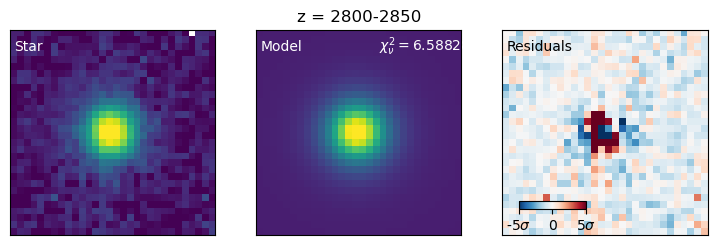

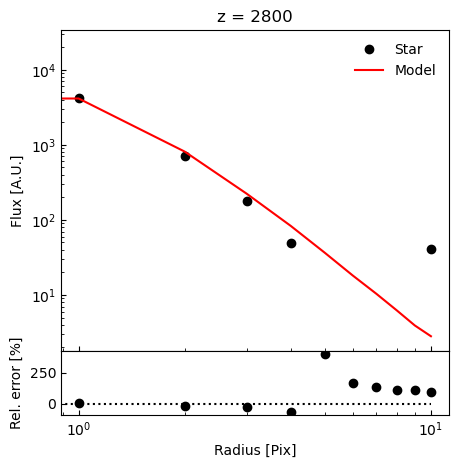

[3000,3050]


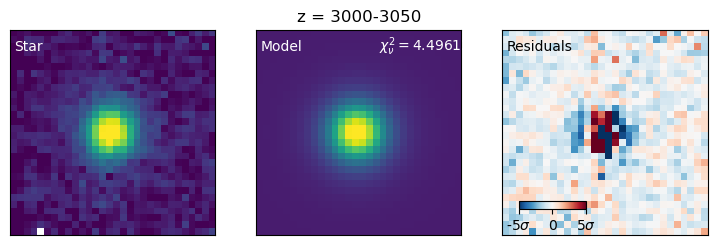

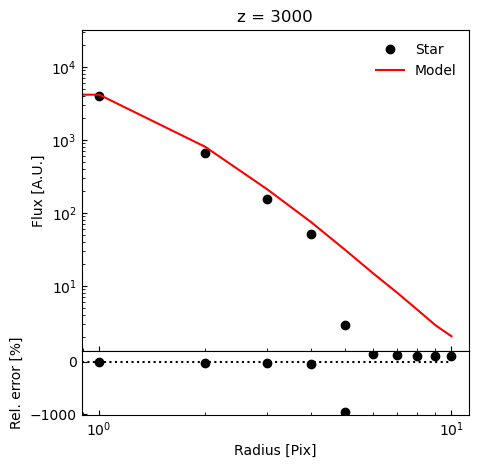

[3200,3250]


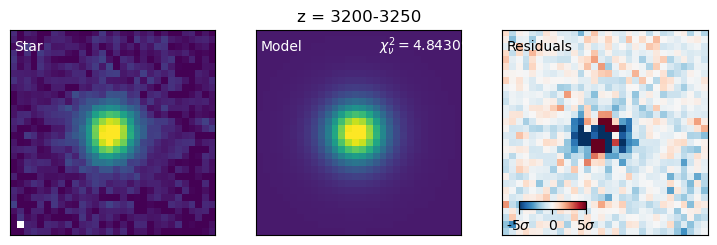

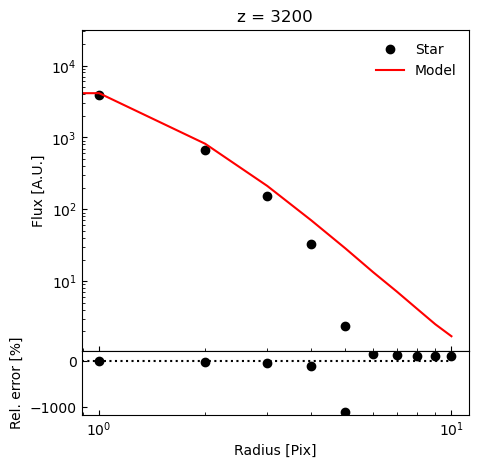

[3400,3450]


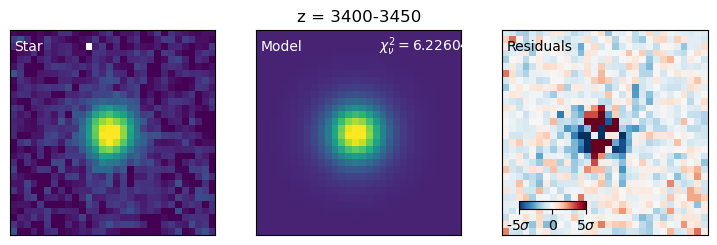

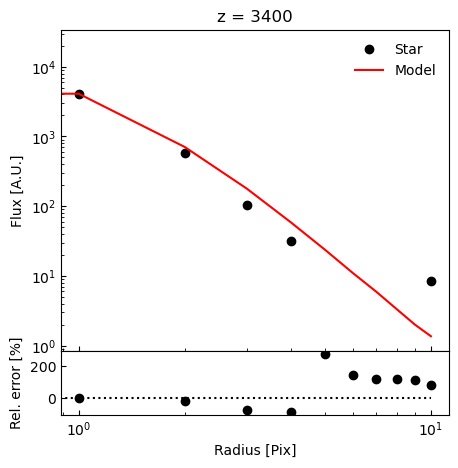

[3600,3650]


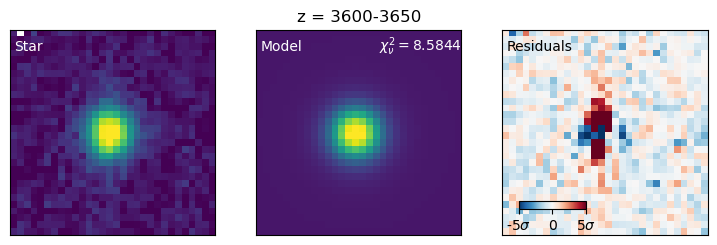

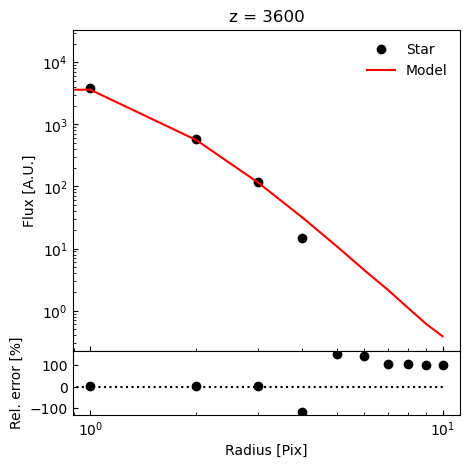

[array([14.07492003, 14.7402268 ,  1.07929785,  3.1745692 ,  1.93367047]), array([14.05726715, 14.74107918,  1.0790166 ,  3.24317079,  1.93367047]), array([14.08590344, 14.70405184,  1.08723489,  3.31801678,  1.96895169]), array([14.11537782, 14.7158605 ,  1.11032433,  3.32794324,  1.98121755]), array([14.14099545, 14.7393368 ,  1.11349606,  3.38393661,  2.05965346]), array([14.19946309, 14.72278275,  1.12988068,  3.36599665,  2.05546761]), array([14.25324112, 14.72613007,  1.09390119,  3.44478135,  2.13520875]), array([14.30692739, 14.69538256,  1.11609379,  3.37793493,  2.01318405]), array([14.32191152, 14.68463046,  1.12001773,  3.32876604,  2.04101617]), array([14.34915206, 14.69122793,  1.15060116,  3.34844792,  2.16591073]), array([14.35633503, 14.70499375,  1.21284918,  3.20836769,  2.04791886]), array([14.33639745, 14.71460308,  1.25656761,  3.1154261 ,  1.99454717]), array([14.31882253, 14.71972979,  1.26926497,  3.06063925,  1.96062348]), array([14.27699865, 14.66897549,  1.2

In [54]:
# Fitting the star along the MUSE spectral range using normalized data

# Provide star's coordinates in the astropy's format
star_coord = star_radec[0]
star_psf = FHMW_Beta_list[0]  # PSF MODEL SELECTION

star_FHWM, star_beta = star_psf[0], star_psf[1]

star_flux = flux_list[0]

coord = SkyCoord(star_coord[0], star_coord[1], unit='deg', frame='icrs', equinox='J2000')
print(coord)

# Set cutout size in pixels
cutout_size = 30
x, y = np.meshgrid(np.arange(cutout_size), np.arange(cutout_size))

# Initial guess for Moffat parameters
x0_guess = cutout_size / 2
y0_guess = cutout_size / 2

# beta mas grande = alas más apretadas
#guess = [float(x0_guess), float(y0_guess), 1.2, 3.5, 3.5]
#lo_bounds = [x0_guess - 5, y0_guess - 5, 0, 1, 1]
#up_bounds = [x0_guess + 5, y0_guess + 5, 4, 5, 8]

#guess = [float(x0_guess), float(y0_guess), star_flux, star_FHWM, star_beta]
#guess = [12.19190346, 11.8708457,   1.09758863,  3.06052643,  2.56841205]

guess = [12.06447273, 11.84000283,  1.07655817,  3.06052643,  2.66879]

lo_bounds = [x0_guess - 5, y0_guess - 5, star_flux*0.8, star_FHWM*0.8, star_beta*0.8]
up_bounds = [x0_guess + 5, y0_guess + 5, star_flux*1.5, star_FHWM*1.5, star_beta*1.5]

for val, low, high in zip(guess, lo_bounds, up_bounds):
    print(f"param: {val}, bounds: [{low}, {high}], in bounds: {low <= val <= high}")

print("----------------------------------------------------------------------------")

z_fitstep, z_plotstep = 50, 200
par_list = []

for k in np.arange(0, cube.shape[0], z_fitstep):



    img = np.nansum(cube[k:k+z_fitstep, :, :], axis=0)
    if np.all(np.isnan(img)):
        par_list.append([np.nan] * len(guess))
        continue

    # Cutout of image and error cube
    cutout = Cutout2D(img, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    cutout_img = cutout.data
    del cutout


    #img_var = np.nansum(vcube[k:k+z_fitstep, :, :], axis=0)
    #img_err = np.sqrt(img_var)  # <- raíz de la varianza
    #cutout = Cutout2D(img_err, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    #cutout_img_err = cutout.data


    img_var = np.nansum(vcube[k:k+z_fitstep, :, :], axis=0)
    cutout = Cutout2D(img_var, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    cutout_img_err = cutout.data
    del cutout

    # Mask invalid pixels
    mask = (cutout_img == 0) | np.isnan(cutout_img)
    x_aux = x[~mask]
    y_aux = y[~mask]
    cutout_img_aux = cutout_img[~mask]
    cutout_img_err_aux = cutout_img_err[~mask]

    if cutout_img_aux.size == 0 or cutout_img_err_aux.size == 0:
        with open("z_trace.txt", "a") as f:
            f.write(f"Empty data at index {k}-{k+z_fitstep}\n")
        par_list.append([np.nan] * len(guess))
        continue

    # Normalización segura
    norm = np.nanmax(cutout_img_aux)
    if not np.isfinite(norm) or norm == 0:
        with open("z_trace.txt", "a") as f:
            f.write(f"Invalid norm at index {k}-{k+z_fitstep}\n")
        par_list.append([np.nan] * len(guess))
        continue

    cutout_img_aux /= norm
    cutout_img_err_aux /= norm

    # Estadísticas de fondo y sustracción
    _, median, std = sigma_clipped_stats(cutout_img_aux * norm, sigma=3.0)
    cutout_img -= median


    test_model = moffat2D((x_aux, y_aux), *guess)

#    print("----------")
#    print("¿NaN en modelo inicial?:", np.any(np.isnan(test_model)))
#    print("¿Inf en modelo inicial?:", np.any(np.isinf(test_model)))
#    print("¿NaN en datos?:", np.any(np.isnan(cutout_img_aux)))
#    print("¿NaN en errores?:", np.any(np.isnan(cutout_img_err_aux)))
#    print("¿NaN en x/y?:", np.any(np.isnan(x_aux)), np.any(np.isnan(y_aux)))
#    print("----------")
 

    try:
        #mask_2 = ~np.isnan(cutout_img_err_aux.ravel())

        #print(f"Total de puntos válidos: {np.sum(mask_2)} de {mask_2.size}")

        popt_psf, pcov_psf = curve_fit(
            moffat2D,
            (x_aux.ravel(), y_aux.ravel()),
            cutout_img_aux.ravel(),
            p0=guess,
            sigma=cutout_img_err_aux.ravel(),
            bounds=(lo_bounds, up_bounds)
            )

        par_list.append(popt_psf)
        #print(popt_psf)
    except RuntimeError:
        with open("z_trace.txt", "a") as f:
            f.write(f"Fit failed at index {k}\n")
        par_list.append([np.nan] * len(guess))
        continue

    if k % z_plotstep == 0:
        print(f"[{k},{k+z_fitstep}]")
        fit_aux = moffat2D((x_aux, y_aux), *popt_psf)

        fit = cutout_img * 0
        fit[~mask] = fit_aux * norm  # des-normaliza el modelo
        resid = (cutout_img - fit) / std  # residuales en unidades de ruido

        do_imshow_plot(cutout_img, fit, resid, Npars=len(popt_psf), title=f'z = {k}-{k+z_fitstep}')

        radius = np.sqrt((x - popt_psf[0]) ** 2 + (y - popt_psf[1]) ** 2)
        r_prof, img_prof, fit_prof = radial_prof(cutout_img, radius, model=fit)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.plot(r_prof, img_prof, 'ok', label='Star')
        ax.plot(r_prof, fit_prof, '-r', label='Model')
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.tick_params(axis="both", direction="in", which='both')
        ax.set_ylabel('Flux [A.U.]')
        ax.set_title(f'z = {k}')
        ax.legend(frameon=False)

        divider = make_axes_locatable(ax)
        ax2 = divider.append_axes("bottom", size="20%", pad=0)
        ax.figure.add_axes(ax2)
        ax2.plot(r_prof, 100 * (1 - fit_prof / img_prof), 'ok')
        ax2.plot(r_prof, img_prof * 0, ':k', linewidth=1.5)
        ax2.set_xscale('log')
        ax2.tick_params(axis="both", direction="in", which='both')
        ax2.set_ylabel('Rel. error [%]')
        ax2.set_xlabel('Radius [Pix]')
        plt.show()


print(par_list)


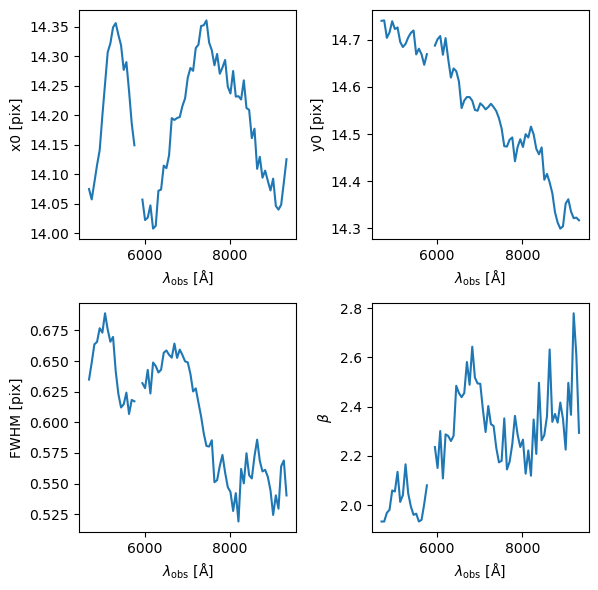

In [55]:
z_arr, par_arr = np.arange(0, np.shape(cube)[0], z_fitstep), np.array(par_list)


wl_obs = (z_arr - (header['CRPIX3']-1)) * header['CD3_3'] + header['CRVAL3']               
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6,6))
   
ax[0,0].plot(wl_obs, par_arr[:,0])
ax[0,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,0].set_ylabel('x0 [pix]')

ax[0,1].plot(wl_obs, par_arr[:,1])
ax[0,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[0,1].set_ylabel('y0 [pix]')


ax[1,0].plot(wl_obs, par_arr[:,3]*0.2)
ax[1,0].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,0].set_ylabel('FWHM [pix]')
#ax[1,0].legend(frameon=False)

ax[1,1].plot(wl_obs, par_arr[:,4])
ax[1,1].set_xlabel(r'$\lambda_{\rm obs}$ [$\mathrm{\AA}$]')
ax[1,1].set_ylabel(r'$\beta$')

fig.tight_layout()
plt.show()

### Interpolate FWHM and beta

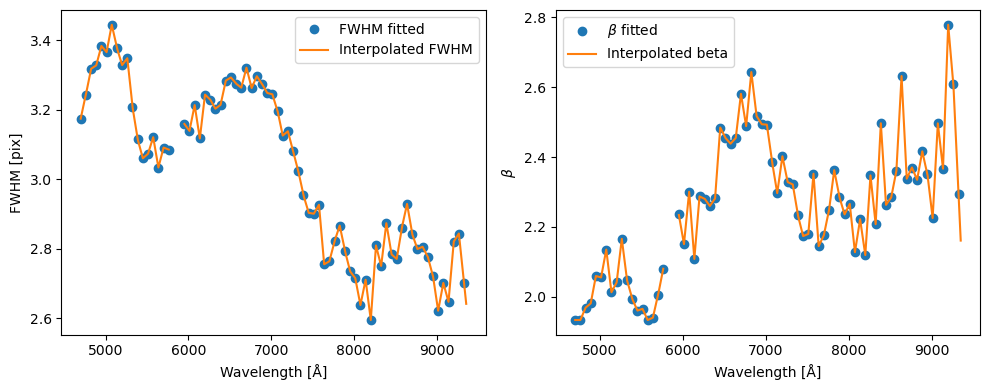

In [53]:
from scipy.interpolate import interp1d


z_arr = np.arange(0, cube.shape[0], z_fitstep)
par_arr = np.array(par_list)
fwhm_vals = par_arr[:, 3]
beta_vals = par_arr[:, 4]

# Graficar los parámetros FWHM y beta ajustados y su interpolación
wl_obs_sub = (z_arr - (header['CRPIX3'] -1)) * header['CD3_3'] + header['CRVAL3']
full_wl_obs = (np.arange(header['NAXIS3']) - (header['CRPIX3'] -1)) * header['CD3_3'] + header['CRVAL3']
f_interp = interp1d(z_arr, fwhm_vals, kind='linear', bounds_error=False, fill_value='extrapolate')
b_interp = interp1d(z_arr, beta_vals, kind='linear', bounds_error=False, fill_value='extrapolate')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(wl_obs_sub, fwhm_vals, 'o', label='FWHM fitted')
ax[0].plot(full_wl_obs, f_interp(np.arange(header['NAXIS3'])), '-', label='Interpolated FWHM')
ax[0].set_ylabel('FWHM [pix]')
ax[0].set_xlabel('Wavelength [Å]')
ax[0].legend()

ax[1].plot(wl_obs_sub, beta_vals, 'o', label=r'$\beta$ fitted')
ax[1].plot(full_wl_obs, b_interp(np.arange(header['NAXIS3'])), '-', label='Interpolated beta')
ax[1].set_ylabel(r'$\beta$')
ax[1].set_xlabel('Wavelength [Å]')
ax[1].legend()

plt.tight_layout()
plt.show()

### Go trought wavelenght (QSO) using star psf

In [178]:
# Inicialización de listas para almacenar parámetros por fuente
x_fit_list = [[] for _ in range(Nsources)]
y_fit_list = [[] for _ in range(Nsources)]
flux_fit_list = [[] for _ in range(Nsources)]
fwhm_fit_list = [[] for _ in range(Nsources)]
beta_fit_list = [[] for _ in range(Nsources)]

# Parámetros iniciales
initial_guesses = np.array([
    [27.919120, 23.578430, 0.694135, 3.196297, 2.104049],
    [32.159181, 25.133712, 0.839981, 3.163697, 2.379327],
    [23.898267, 28.169255, 0.993171, 3.094371, 2.398522],
    [29.491854, 28.854480, 0.609408, 3.307899, 2.583371],
    [30.065869, 40.172504, 0.269234, 3.262459, 2.761125],
    [26.050496, 49.721804, 0.017482, 3.090589, 5.115214]
])

n_spectral = cube.shape[0]

# Recorrer eje espectral
for i in range(n_spectral):
    z = wave_obs[i]  # o usa tu variable de long. de onda si ya está definida
    
    image = cube[i, :, :]
    error = np.sqrt(vcube)[i, :, :]
    
    # Cutout por canal espectral
    cutout = Cutout2D(image, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    img = cutout.data
    cutout_err = Cutout2D(error, coord, size=cutout_size, wcs=wcs_2d, mode='partial', fill_value=0)
    img_err = cutout_err.data

    del cutout, cutout_err
    
    szy, szx = np.shape(img)
    x, y = np.meshgrid(np.arange(szx), np.arange(szy))
    
    mask = (img == 0) | (np.isnan(img))
    x_aux = x[~mask]
    y_aux = y[~mask]
    img_aux = img[~mask]
    img_err_aux = img_err[~mask]

    norm = np.nanmax(img_aux)
    img_aux /= norm
    img_err_aux /= norm

    mean, median, std = sigma_clipped_stats(img_aux * norm, sigma=3.0)
    img -= median
    
    # Parámetros para esta longitud de onda
    guess, up_bounds, lo_bounds = [], [], []

    for j in range(Nsources):
        print(j)
        x0, y0, flux0, _, _ = initial_guesses[j]
        fwhm = f_interp(z)
        beta = b_interp(z)

        guess += [x0, y0, flux0] + [fwhm, beta]
        up_bounds += [x0 + 10, y0 + 10, flux0 * 1.5, fwhm * 1.05, beta * 1.05]
        lo_bounds += [x0 - 10, y0 - 10, flux0 * 0.01, fwhm * 0.95, beta * 0.95]

        for lo, up, g in zip(lo_bounds, up_bounds, guess):
            if lo >= up:
                print(f"Problema: lo={lo}, up={up}, guess={g}")


    try:
        popt, pcov = curve_fit(lens_qso_fit,
                               (x, y),
                               img_aux.ravel(),
                               p0=guess,
                               sigma=img_err_aux.ravel(),
                               bounds=(lo_bounds, up_bounds),
                               maxfev=10000)
    except RuntimeError:
        print(f"Ajuste falló en z = {z:.2f}")
        continue

    # Guardar parámetros ajustados para cada fuente
    for j in range(Nsources):
        x_fit_list[j].append(popt[j*5 + 0])
        y_fit_list[j].append(popt[j*5 + 1])
        flux_fit_list[j].append(popt[j*5 + 2])
        fwhm_fit_list[j].append(popt[j*5 + 3])
        beta_fit_list[j].append(popt[j*5 + 4])


0
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
1
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
2
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.025379522867908
Problema: lo=-0.1407369647669326, up=-0.15555138211082026, guess=-0.14814417343887643
Problema: lo=-3.8241105467245124, up=-4.226648499011303, guess=-4.02

ValueError: Each lower bound must be strictly less than each upper bound.